In [7]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [8]:
import json
import logging
from pathlib import Path

import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import tomllib

from src.log_config import configure_logging
from src.models.data_loader import create_dataloaders
from src.models.data_preparation import (
    expand_feature_list,
    load_data_from_database,
    prepare_data,
)
from src.models.main_config import RANDOM_SEED
from src.models.utils import load_model
from src.plots.model_inference import (
    analyze_test_dataset_for_one_stimulus,
    plot_prediction_confidence_heatmap,
    plot_single_prediction_confidence_heatmap,
)

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)


In [9]:
config_path = Path("src/experiments/measurement/measurement_config.toml")
with open(config_path, "rb") as file:
    config = tomllib.load(file)
stimulus_seeds = config["stimulus"]["seeds"]
print(f"Using seeds for stimulus generation: {stimulus_seeds}")

Using seeds for stimulus generation: [133, 243, 265, 396, 467, 658, 681, 743, 806, 841, 870, 952]


In [10]:
feature_lists = [
    # ["eda_raw", "pupil"],
    # ["eda_raw", "heart_rate"],
    # ["eda_raw", "heart_rate", "pupil"],
    # ["face"],
    ["eeg"],
]
feature_lists = expand_feature_list(feature_lists)
feature_list = feature_lists[0]
feature_list_str = "_".join(feature_list)

In [11]:
results = {}

# Load data from database
df = load_data_from_database(feature_list=feature_list)

# Load model
json_path = Path(f"results/experiment_{feature_list_str}/results.json")
dictionary = json.loads(json_path.read_text())
model_path = Path(dictionary["overall_best"]["model_path"].replace("\\", "/"))

model, feature_list, sample_duration_ms, intervals, label_mapping, offsets_ms = (
    load_model(model_path, device="cpu")
)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

23:18:20 | INFO    | utils | Using device: cpu
23:18:20 | INFO    | utils | Loaded EEGNet model with test accuracy 0.59 to cpu
23:18:20 | INFO    | utils | Input shape: (1750, 8) | Features: ['f3', 'f4', 'c3', 'cz', 'c4', 'p3', 'p4', 'oz'] | Sample duration: 7000 ms
23:18:20 | DEBUG   | utils | Intervals: {'increases': 'strictly_increasing_intervals', 'plateaus': 'plateau_intervals', 'decreases': 'major_decreasing_intervals'}
23:18:20 | DEBUG   | utils | Label mapping: {'increases': 0, 'plateaus': 0, 'decreases': 1}
23:18:20 | DEBUG   | utils | Offset ms: {'increases': 0, 'plateaus': 5000, 'decreases': 1000}


In [ ]:
# Prepare data
_, _, _, _, X_train_val, y_train_val, X_test, y_test = prepare_data(
    df=df,
    feature_list=feature_list,
    sample_duration_ms=sample_duration_ms,
    intervals=intervals,
    label_mapping=label_mapping,
    offsets_ms=offsets_ms,
    random_seed=RANDOM_SEED,
)
test_groups = prepare_data(
    df=df,
    feature_list=feature_list,
    sample_duration_ms=sample_duration_ms,
    intervals=intervals,
    label_mapping=label_mapping,
    offsets_ms=offsets_ms,
    random_seed=RANDOM_SEED,
    only_return_test_groups=True,
)
test_ids = np.unique(test_groups)
# train data is not used in this analysis, but we need to create the dataloaders
_, test_loader = create_dataloaders(
    X_train_val, y_train_val, X_test, y_test, batch_size=64
)


23:18:23 | WARNING | sample_creation | Sampling rate is not equidistant with 10 Hz.
23:18:27 | DEBUG   | data_preparation | Preparing data with sample duration 7000 ms and random seed 42
23:18:27 | DEBUG   | data_preparation | Samples are based on intervals: {'increases': 'strictly_increasing_intervals', 'plateaus': 'plateau_intervals', 'decreases': 'major_decreasing_intervals'}
23:18:27 | DEBUG   | data_preparation | Offsets for intervals: {'increases': 0, 'plateaus': 5000, 'decreases': 1000}
23:18:27 | DEBUG   | data_preparation | Label mapping: {'increases': 0, 'plateaus': 0, 'decreases': 1}
23:18:27 | INFO    | data_preparation | Number of unique participants in training set: 24
23:18:27 | INFO    | data_preparation | Number of unique participants in validation set: 9
23:18:27 | INFO    | data_preparation | Number of unique participants in test set: 9
23:18:27 | DEBUG   | data_preparation | Participant IDs in test set: [ 5  9 14 20 26 27 30 31 40]
23:18:28 | WARNING | sample_creati

In [14]:
df

trial_id,trial_number,participant_id,timestamp,f3,f4,c3,cz,c4,p3,p4,oz,normalized_timestamp,stimulus_seed,skin_patch,decreasing_intervals,major_decreasing_intervals,increasing_intervals,strictly_increasing_intervals,strictly_increasing_intervals_without_plateaus,plateau_intervals,prolonged_minima_intervals
u16,u8,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u16,u8,u16,u16,u16,u16,u16,u16,u16
1,1,1,216940.3005,-2.0428e-14,2.5480e-12,1.4277e-12,1.8789e-12,2.3834e-12,-7.4474e-13,3.5290e-12,-4.9960e-15,0.0,243,1,0,0,1,0,0,0,0
1,1,1,216944.0628,36.215756,38.623169,36.793974,38.023269,38.381408,40.83865,35.842668,34.765243,3.7623,243,1,0,0,1,0,0,0,0
1,1,1,216948.0696,82.124126,92.883143,83.587051,91.005893,91.710653,95.496317,87.574106,85.924382,7.7691,243,1,0,0,1,0,0,0,0
1,1,1,216952.132,72.591659,82.607926,75.210979,83.518908,85.043701,87.604904,81.858174,77.411817,11.8315,243,1,0,0,1,0,0,0,0
1,1,1,216955.9735,36.521192,38.429742,39.03288,41.224318,40.175841,42.038494,37.271644,37.422558,15.673,243,1,0,0,1,0,0,0,0
1,1,1,216960.0794,3.835589,3.191793,7.085367,7.604406,6.01906,5.940223,4.730759,7.21841,19.7789,243,1,0,0,1,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
480,12,42,2.8189e6,8.031504,8.641152,10.057569,12.018488,9.541066,19.600744,10.191622,10.67999,180005.0593,681,6,0,0,0,0,0,0,0
480,12,42,2.8189e6,-8.33614,-7.597183,9.910422,1.3081,-1.991607,9.383323,0.173139,-2.925576,180009.1011,681,6,0,0,0,0,0,0,0


In [15]:
feature_list

['f3', 'f4', 'c3', 'cz', 'c4', 'p3', 'p4', 'oz']

In [13]:
# Analyze the entire test dataset
all_probabilities = {}
all_participant_trials = {}

for stimulus_seed in stimulus_seeds:
    probabilities, participant_trials = analyze_test_dataset_for_one_stimulus(
        model, feature_list, test_ids, stimulus_seed, sample_duration_ms, log=True
    )

    all_probabilities[stimulus_seed] = probabilities
    all_participant_trials[stimulus_seed] = participant_trials


ColumnNotFoundError: f3

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
DF ["trial_id", "trial_number", "participant_id", "timestamp", ...]; PROJECT */36 COLUMNS

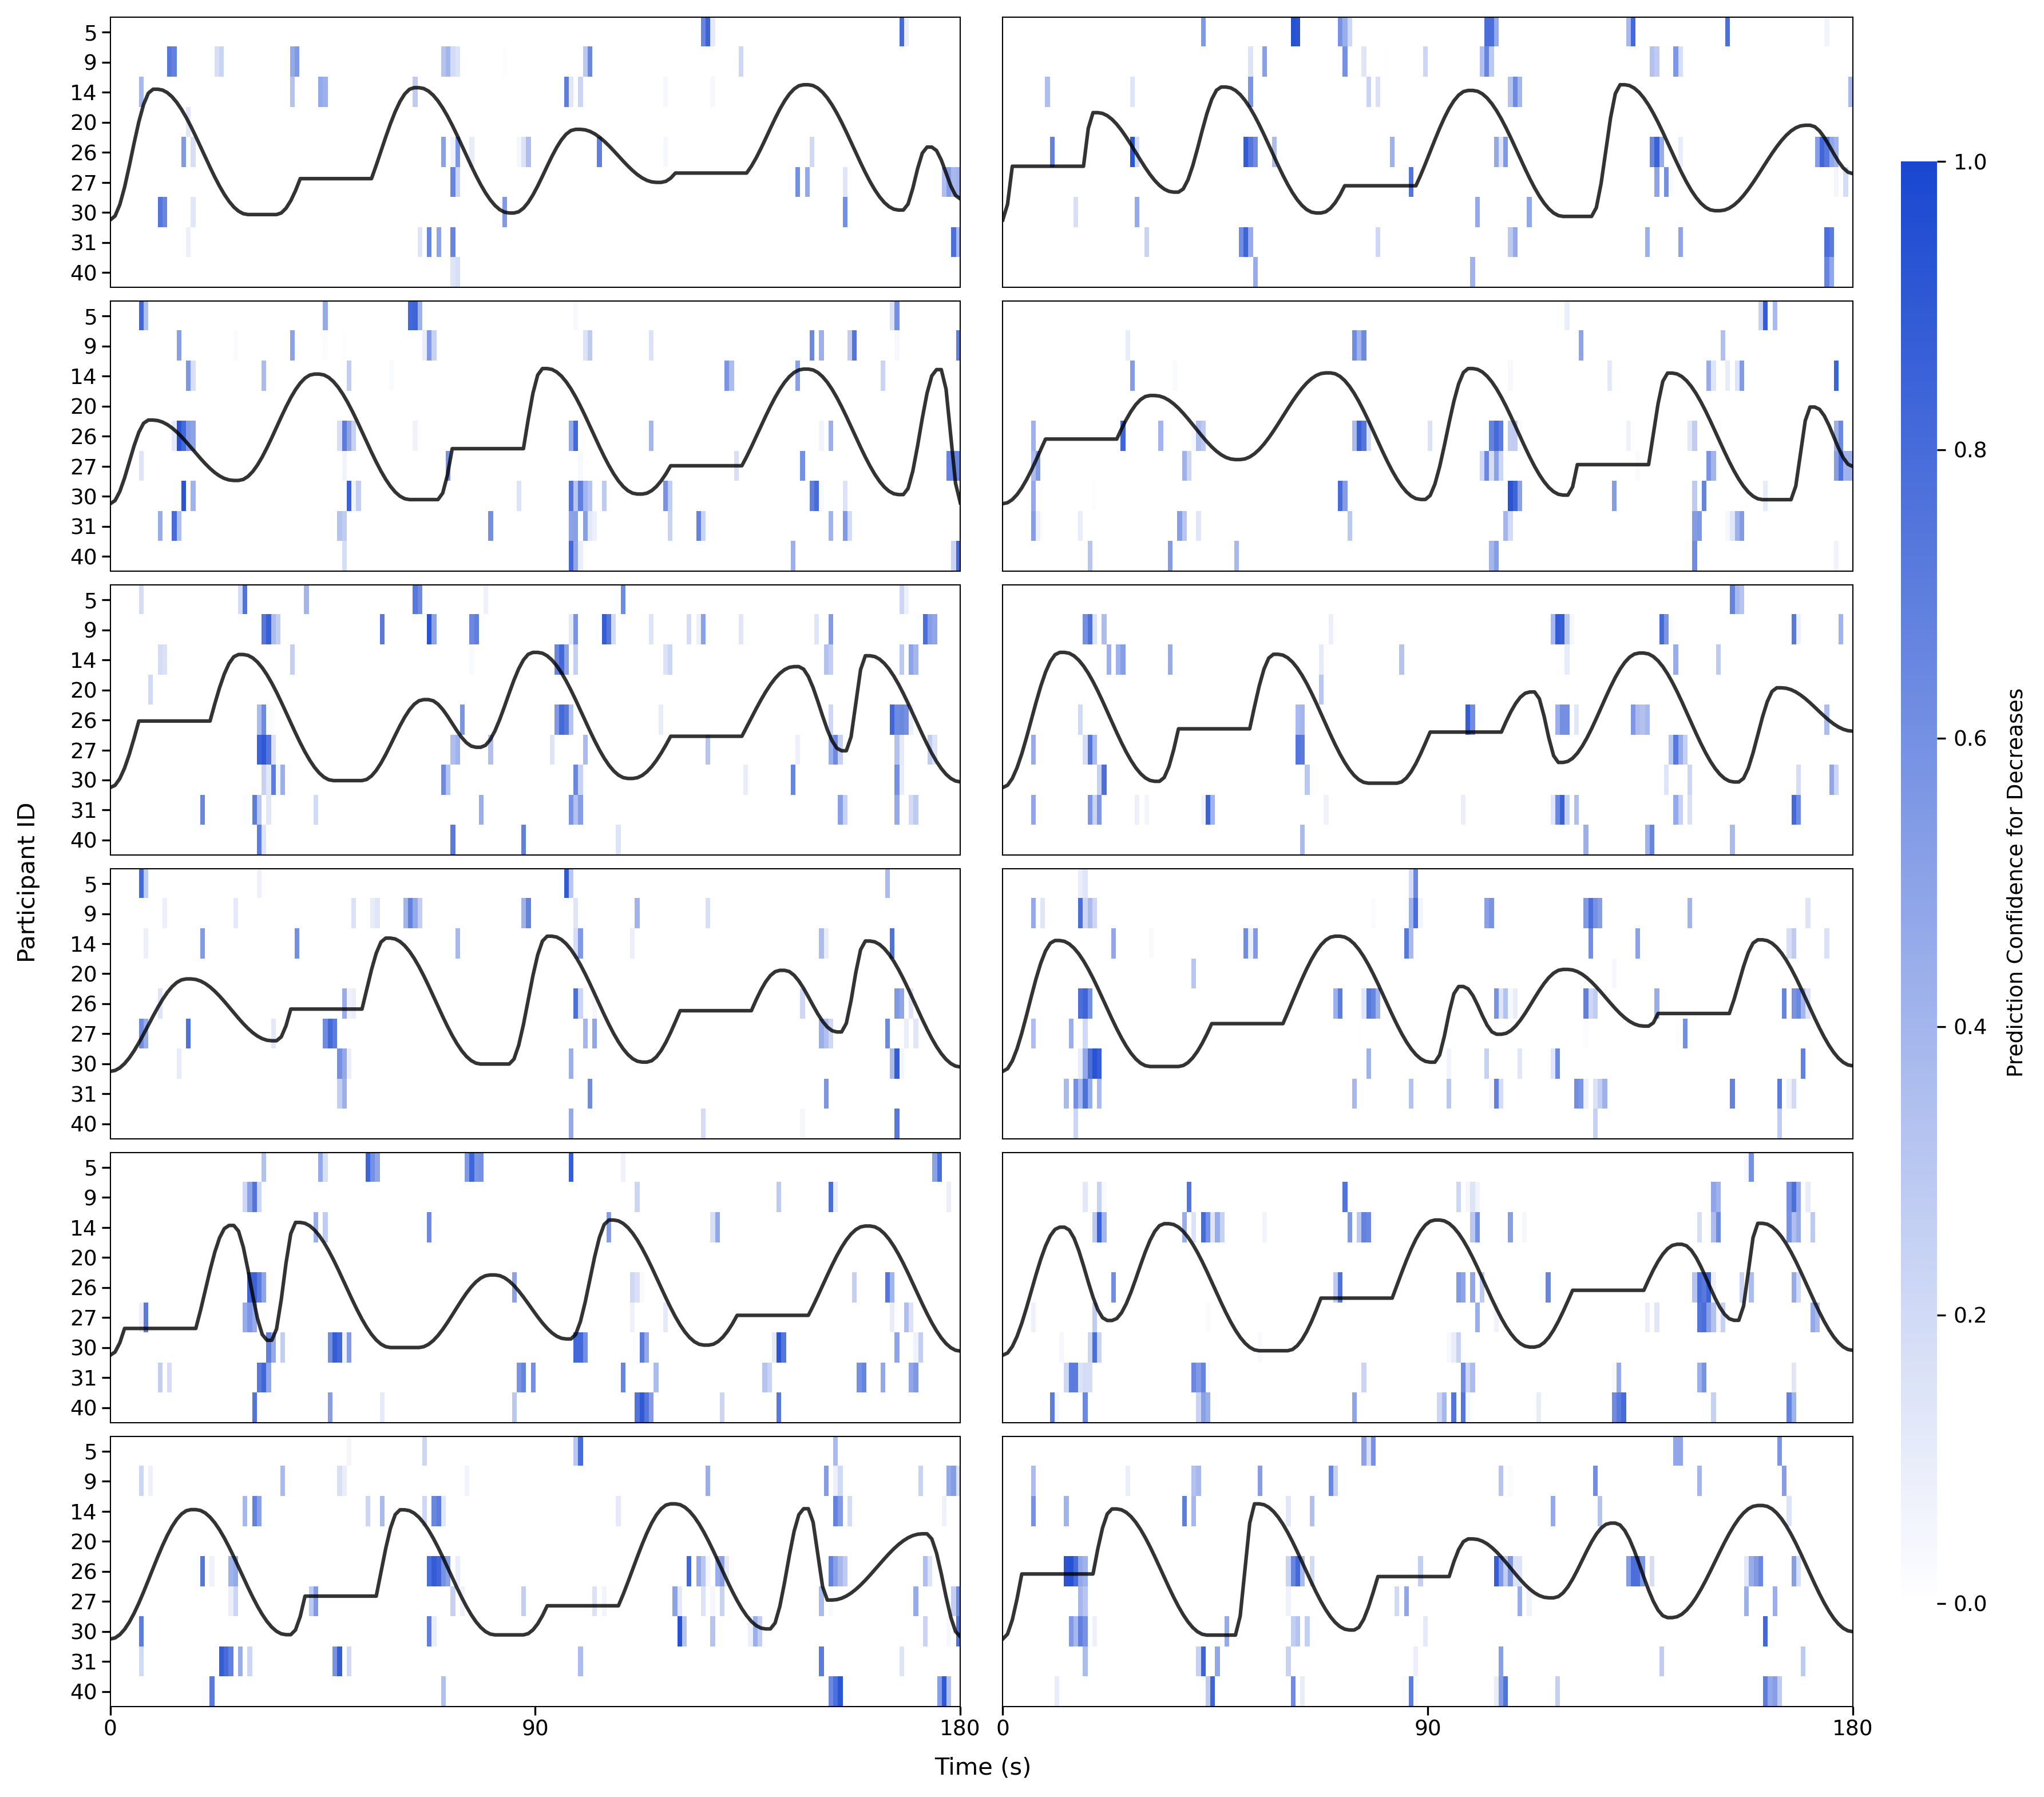

In [ ]:
# Plot all available stimuli
fig = plot_prediction_confidence_heatmap(
    all_probabilities,
    sample_duration_ms,
    classification_threshold=0.95,
    ncols=2,
    figure_size=(7, 2),
    stimulus_scale=0.5,
    stimulus_linewidth=1.5,
    only_decreases=1,
)

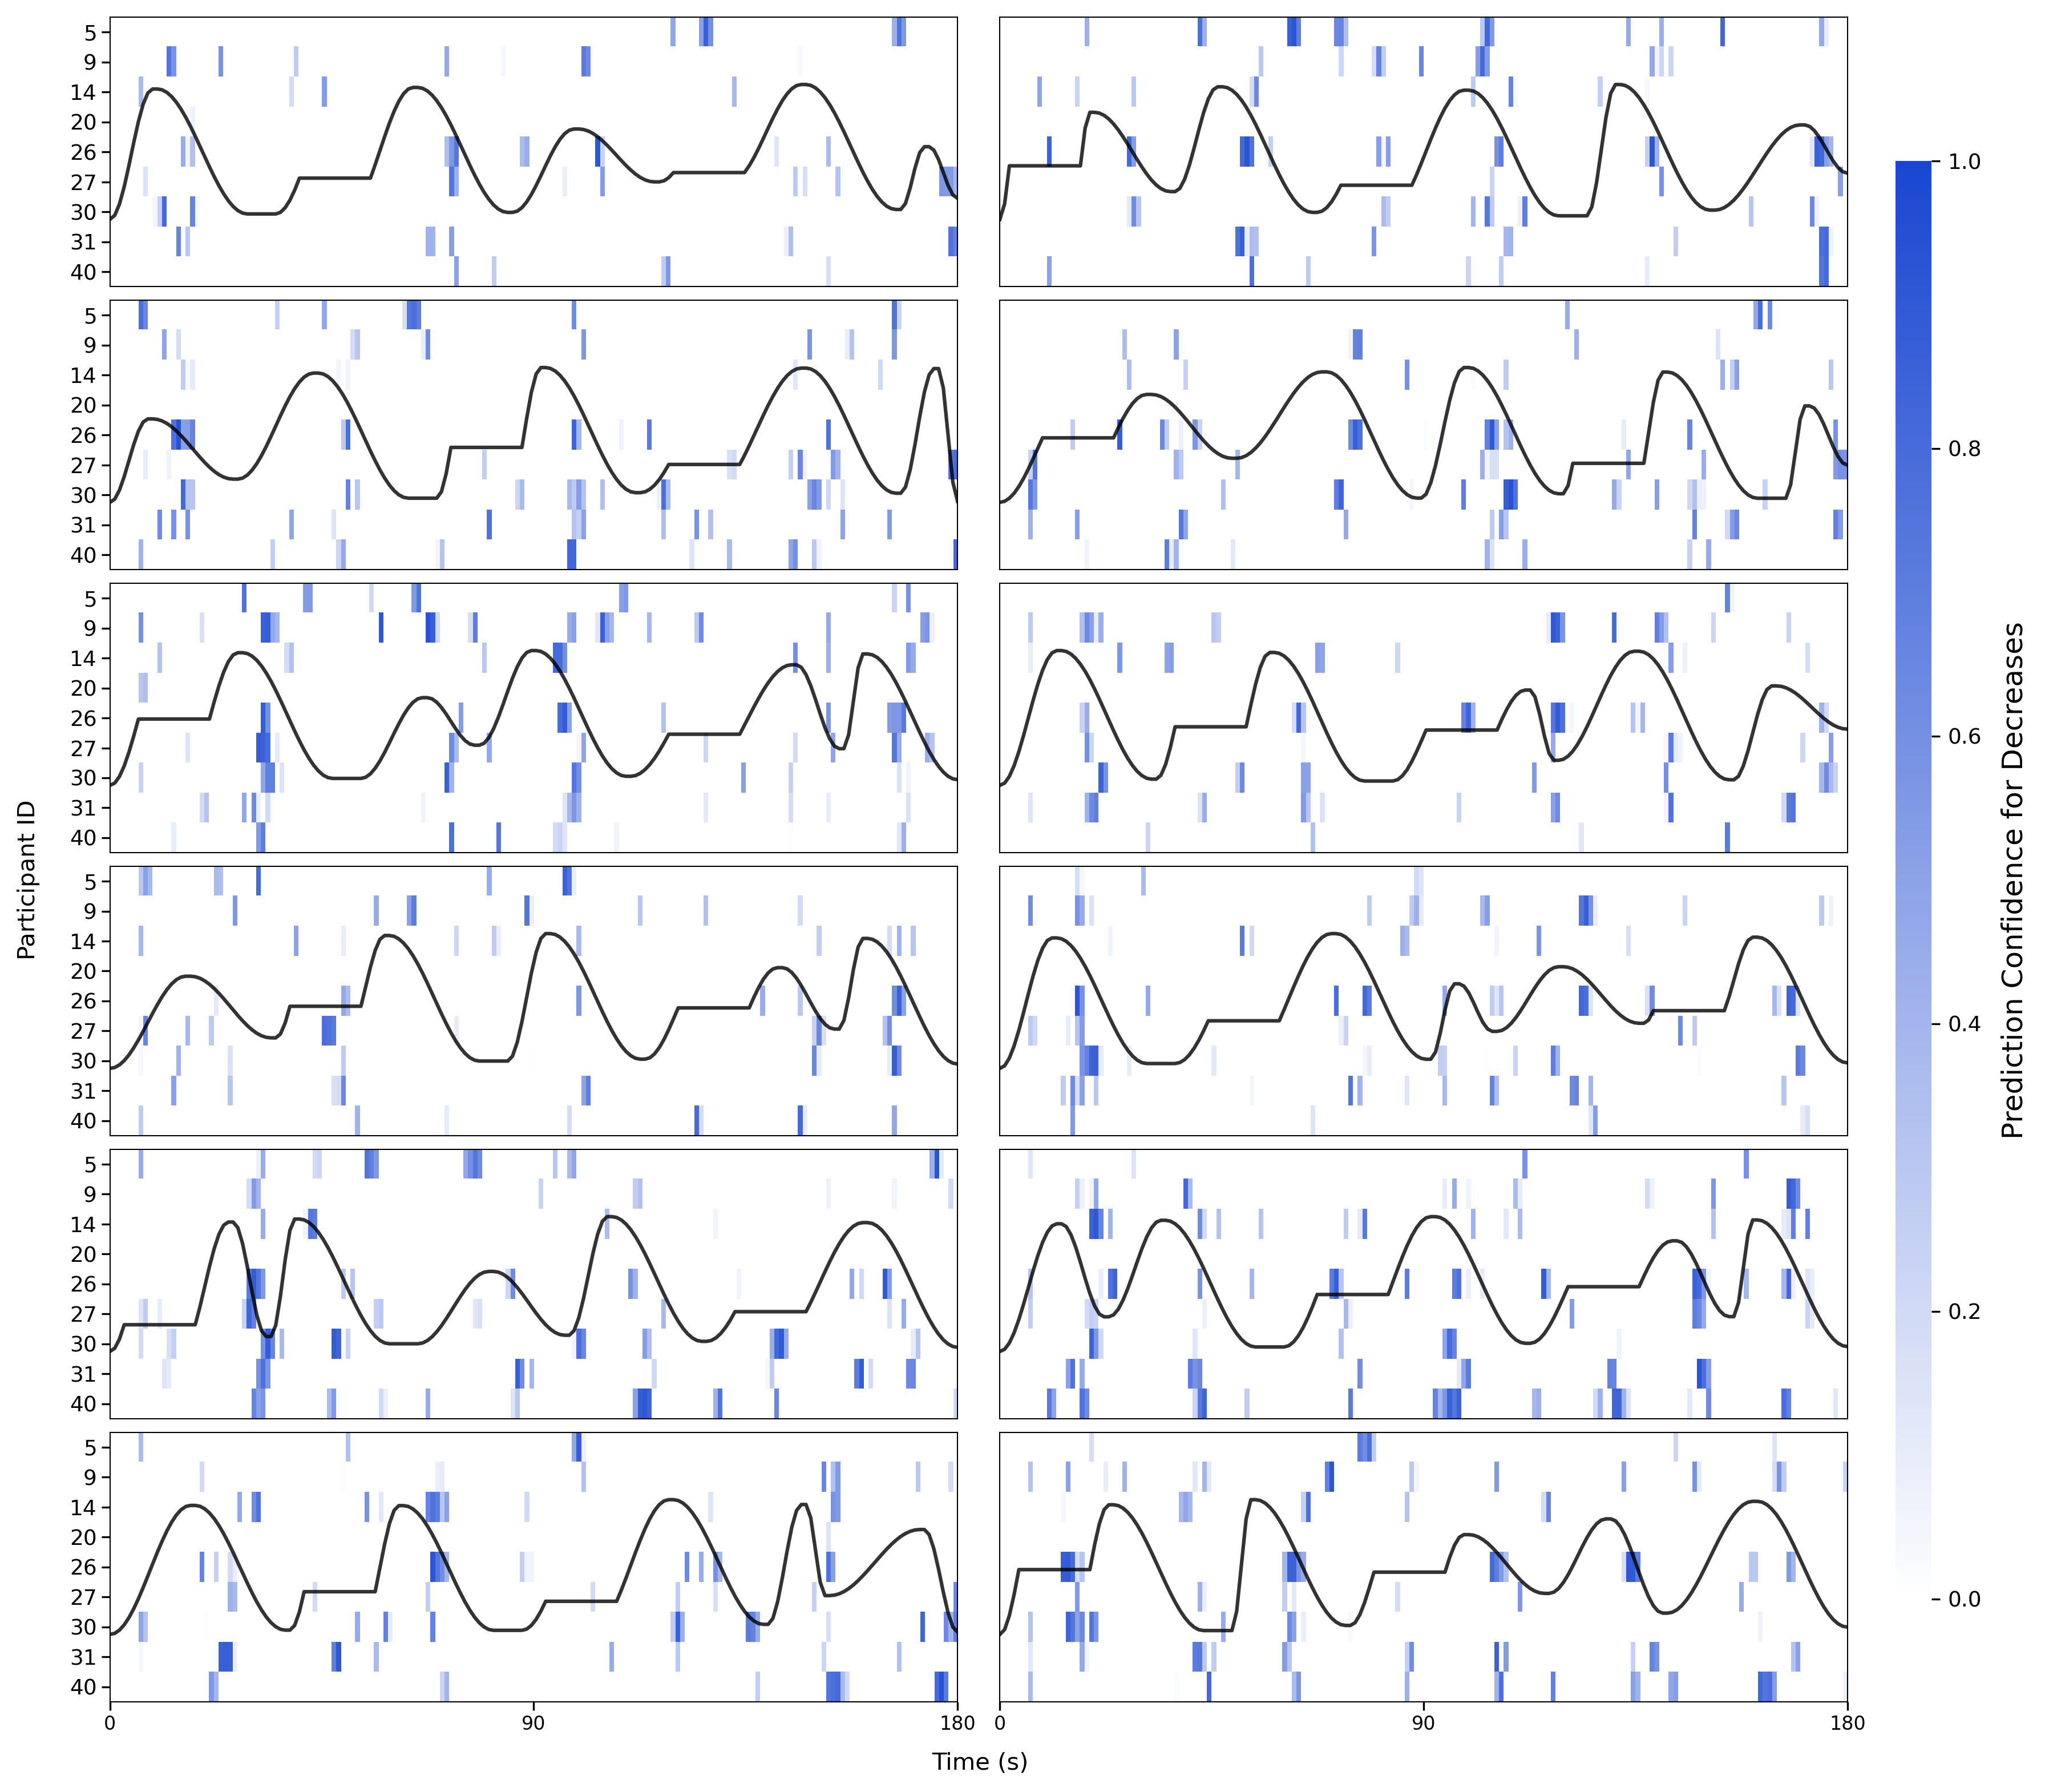

In [ ]:
# Plot all available stimuli
fig = plot_prediction_confidence_heatmap(
    all_probabilities,
    sample_duration_ms,
    classification_threshold=0.95,
    ncols=2,
    figure_size=(7, 2),
    stimulus_scale=0.5,
    stimulus_linewidth=1.5,
    only_decreases=1,
)


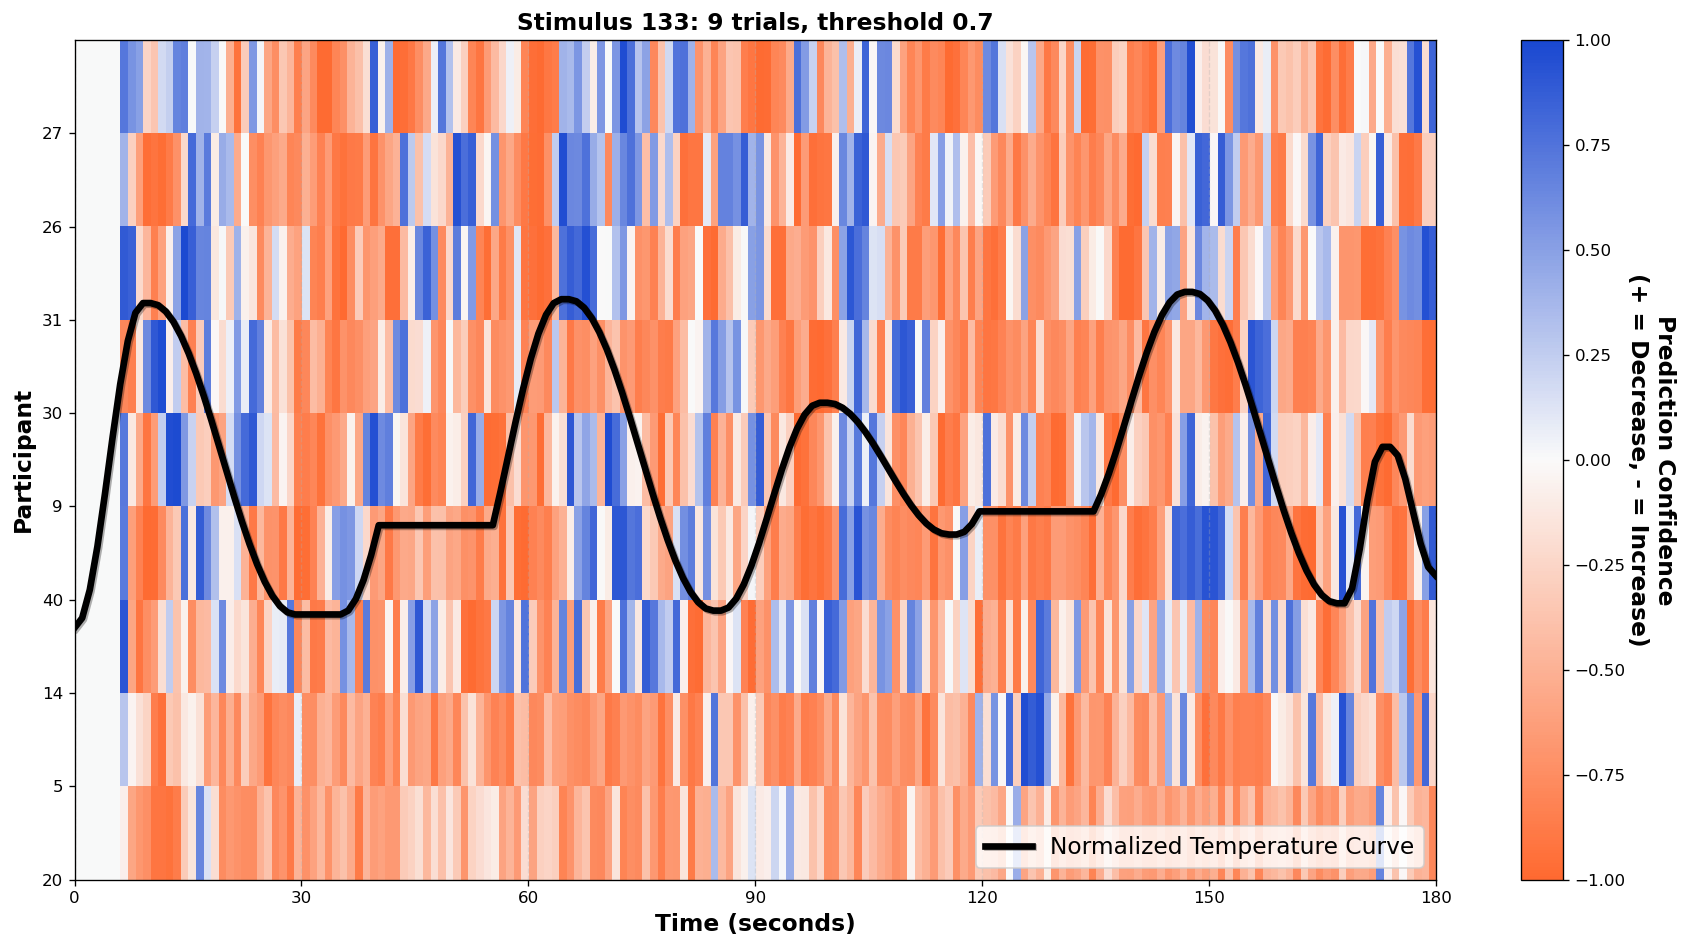

In [ ]:
stimulus_seed = stimulus_seeds[0]
threshold = 0.7

a = plot_single_prediction_confidence_heatmap(
    probabilities=all_probabilities[stimulus_seed],
    stimulus_seed=stimulus_seed,
    classification_threshold=threshold,
    sample_duration=sample_duration_ms,
)